# Topic Modeling using LDA

In this notebook I will present an use case for Latent Dirichlet Allocation, which is Topic Modeling. In machine learning and natural language processing, a topic model is a type of statistical model for discovering the abstract topics that occur in a collection of documents. Topic modeling is frequently used in data mining techniques in an attempt to find hidden semantics in the text data. In general, we use this algorithm to find words that are repeating in a subset of documents, or even finding documents that share a similar topic just by using words from the same field, or synonyms. In our case, we will be looking at finding topic clusters for books, which could be an useful project in an application that can recommend other similar books to the ones you just bought or read. On the most basic level you could just group books together by the author, the year it was written. Other useful information for sorting an entire database of books would be genre or some other literal aspects, such as reviews or comments. But what would happen if the application was not build with keeping in mind that functionality, of grouping books in categories. Here is where the power of LDA begins to show. Intuitively this algorithm is able to find the keywords of an entire dataset just using the text documents that are available. This means that the database containing only text bodies of data can be labeled with keywords easily. The only difficult part is cleaning the data and feature engineering so that the resulting keywords have meaning. Intuitively, we do not want to use words that repeat to often during training, such as "the", "a", "an". We call these types of words stopwords. It depends on the dataset used, but usually we want to include other words in these blacklist too. Some other examples of words that we may consider useless are pronouns ("I", "you", etc.), person names, or any other set of words that would make sense to ignore. Generally we will find these as we work on cleaning the dataset by looking at examples or histograms of word counts.

In this project I will present an use case for Latent Dirichlet Allocation, which is generating topic clusters for a dataset of audio books. The dataset used in this work is [LibriSpeech](https://www.openslr.org/12/). This contains the audio files as well as the transcription of each book, which is what I will be using as training data. However, the dataset is not already preprocessed and we will have to go trough the steps of cleaning the data and modeling. The modeling stage is pretty straight forward, since we just have to showcase the use of LDA. The original data format is presented in the LibriSpeech release and comes with tools that are able to parse the text from the target files. I just had to concatenate each piece of text and group them by book and then saved them in a tabular format. In the end we are left with three comma separated value files, one for the training stage, one for validation and one for testing (or the holdout set).

## Imports

The tools I used for this project are [NLTK](https://www.nltk.org/), which is an open source library, Natural Language Toolkit. NLTK is a leading platform for building Python programs to work with human language data. It provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning, wrappers for industrial-strength NLP libraries, and an active discussion forum. We will be using this library for it's powerful preprocessing techniques, which will in turn make our model yield better results.

The other important library I will be using is [gensim](https://radimrehurek.com/gensim/), which contains the implementation of the LDA algorithm and metrics that will be useful to test the implementation. I will use the gensim library because I am the most familiar with it, in case of topic modeling, it is open source, meaning we have access to look at how it is implemented and it works very fast.

In [1]:
import os
import re

from functools import partial
from collections import Counter

from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords, names
from nltk.stem import WordNetLemmatizer

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.hdpmodel import HdpModel
from gensim.models import CoherenceModel

import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings('ignore')

dataroot = os.path.join(".")

pyLDAvis_outpath = os.path.join(dataroot, "view", "data.html")
id2word_outpath = os.path.join(dataroot, "models", "id2word.dict")
optimal_model_outpath = os.path.join(dataroot, "models", "lda_model.model")

os.makedirs(os.path.join(dataroot, "view"), exist_ok=True)
os.makedirs(os.path.join(dataroot, "models"), exist_ok=True)

## Data Loading

As previously mentioned, the dataset is LibriSpeech, a collection of audio books. However, in this project we are only interested in the text bodies of the audio books, so I saved just the text files alongside with the book titles and the duration of each book, just to be able to discard examples that are too short and would not add any value to the final implementation. For now the text contained in each books is not filtered, so it basically contains the transcript of each audio book.

In [2]:
# The csv files containing the data
train_clean_100_path = os.path.join(dataroot, "data", "train-clean-100.csv")
dev_clean_path = os.path.join(dataroot, "data", "dev-clean.csv")
test_clean_path = os.path.join(dataroot, "data", "test-clean.csv")

# Read the csv files
train_df = pd.read_csv(train_clean_100_path, index_col=0)
dev_df = pd.read_csv(dev_clean_path, index_col=0)
test_df = pd.read_csv(test_clean_path, index_col=0)

train_df =  pd.DataFrame({"TEXT": train_df["REAL TEXT"], "BOOK": train_df["BOOK TITLE"], "DURATION": train_df["DURATION"]})
dev_df = pd.DataFrame({"TEXT": dev_df["TEXT"], "BOOK": dev_df["BOOK TITLE"], "DURATION": dev_df["DURATION"]})
test_df = pd.DataFrame({"TEXT": test_df["TEXT"], "BOOK": test_df["BOOK TITLE"], "DURATION": test_df["DURATION"]})

# Merge data in one dataframe
df = pd.concat([train_df, dev_df, test_df])

# Now we can see we have the content of the book, the title and the duration
df.head()

,TEXT,BOOK,DURATION
0,TILL THEY WOULD FINALLY CIRCLE ROUND AND ROUND...,"The Life of Hon. William F. Cody, Known as Buf...",17.67
1,AS CINCINNATUS OR CORNELIA NOW TO SUCH A QUIET...,"Divine Comedy, Longfellow's Translation, Complete",25.10
2,LOUISE AND BETH HAVING AT LAST FULL KNOWLEDGE ...,Aunt Jane's Nieces,17.11
3,MODE BEARD THE OYSTERS AND SCALD THEM IN THEIR...,The Book of Household Management,5.79
4,SHE SAID SHE WAS NOT ABSOLUTELY CERTAIN OF THE...,The Professor,7.95


We can see that the distribution of the audio books lengths varies quite a lot so we can remove the examples that fall outside the range given using the zscore, in our case we want to keep the data that is at most 3 standard deviations away from the mean. In statistics, the standard score is the number of standard deviations by which the value of a raw score is above or below the mean value of what is being observed or measured. Raw scores above the mean have positive standard scores, while those below the mean have negative standard scores.

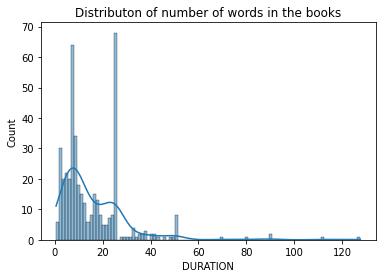

,DURATION
count,422.000000
mean,15.754858
std,14.565170
min,0.540000
25%,7.397500
50%,10.590000
75%,24.840000
max,127.620000


In [3]:
# Lets seee the distribution of the lengths of each sample book
sns.histplot(df['DURATION'], kde=True, bins=100)
plt.title("Distributon of number of words in the books")
plt.show()
df.describe()

In [4]:
# First lets remove the books that are too long or too short from our data using the z score
df = df[(np.abs(stats.zscore(df['DURATION'])) < 3)]

df.head()

,TEXT,BOOK,DURATION
0,TILL THEY WOULD FINALLY CIRCLE ROUND AND ROUND...,"The Life of Hon. William F. Cody, Known as Buf...",17.67
1,AS CINCINNATUS OR CORNELIA NOW TO SUCH A QUIET...,"Divine Comedy, Longfellow's Translation, Complete",25.10
2,LOUISE AND BETH HAVING AT LAST FULL KNOWLEDGE ...,Aunt Jane's Nieces,17.11
3,MODE BEARD THE OYSTERS AND SCALD THEM IN THEIR...,The Book of Household Management,5.79
4,SHE SAID SHE WAS NOT ABSOLUTELY CERTAIN OF THE...,The Professor,7.95


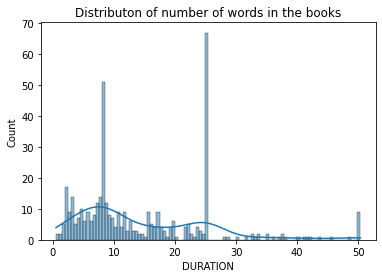

,DURATION
count,416.000000
mean,14.611995
std,10.845341
min,0.540000
25%,7.317500
50%,10.480000
75%,23.920000
max,50.340000


In [5]:
# Lets seee the distribution of the lengths of each sample book
sns.histplot(df['DURATION'], kde=True, bins=100)
plt.title("Distributon of number of words in the books")
plt.show()
df.describe()

In [6]:
# Now lets convert each string to lower case
df['TEXT'] = df['TEXT'].apply(str.lower)
df.head()

,TEXT,BOOK,DURATION
0,till they would finally circle round and round...,"The Life of Hon. William F. Cody, Known as Buf...",17.67
1,as cincinnatus or cornelia now to such a quiet...,"Divine Comedy, Longfellow's Translation, Complete",25.10
2,louise and beth having at last full knowledge ...,Aunt Jane's Nieces,17.11
3,mode beard the oysters and scald them in their...,The Book of Household Management,5.79
4,she said she was not absolutely certain of the...,The Professor,7.95


After we have removed the samples that were either too long or too short, we can focus on cleaning the wording of the books. I started with expanding the abbreviations, or contractions between the pronouns and verbs, from the dataset. This will allow us to have less tokens in the list of stopwords and will make the process easier to follow.

In [7]:
# Now lets decontract words that contain "'"

# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
def decontract(phrase: str):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

df['TEXT'] = df['TEXT'].apply(decontract)
df.head()

,TEXT,BOOK,DURATION
0,till they would finally circle round and round...,"The Life of Hon. William F. Cody, Known as Buf...",17.67
1,as cincinnatus or cornelia now to such a quiet...,"Divine Comedy, Longfellow's Translation, Complete",25.10
2,louise and beth having at last full knowledge ...,Aunt Jane's Nieces,17.11
3,mode beard the oysters and scald them in their...,The Book of Household Management,5.79
4,she said she was not absolutely certain of the...,The Professor,7.95


 Another important step in the process of data cleaning is work tokenization, where we have to split the text stream into words. After this step we could even run the LDA algorithm, but we would get really bad results from a human perspective, since the algorithm will only care about maximizing the score, and will most likely choose the most frequent words as keywords, such as the aforementioned stopwords, "the", "an", "a", etc.

In [8]:
# Now lets tokanize the text string into a list of words
df['TEXT'] = df['TEXT'].apply(word_tokenize)
df.head()

,TEXT,BOOK,DURATION
0,"[till, they, would, finally, circle, round, an...","The Life of Hon. William F. Cody, Known as Buf...",17.67
1,"[as, cincinnatus, or, cornelia, now, to, such,...","Divine Comedy, Longfellow's Translation, Complete",25.10
2,"[louise, and, beth, having, at, last, full, kn...",Aunt Jane's Nieces,17.11
3,"[mode, beard, the, oysters, and, scald, them, ...",The Book of Household Management,5.79
4,"[she, said, she, was, not, absolutely, certain...",The Professor,7.95


To speed up the rest of the pipeline we will be removing words that are short, less than three letters is a good enough threshold for the English language. This will remove most of the stopwords and pronouns, but still leave some other examples in that can be eliminated.

In [9]:
# Now lets remove short words from our text
# how short is a short words
_short = 3

def is_not_short(word):
    return len(word) > _short

df['TEXT'] = df['TEXT'].apply(partial(filter, is_not_short)).apply(list)
df.head()

,TEXT,BOOK,DURATION
0,"[till, they, would, finally, circle, round, ro...","The Life of Hon. William F. Cody, Known as Buf...",17.67
1,"[cincinnatus, cornelia, such, quiet, such, bea...","Divine Comedy, Longfellow's Translation, Complete",25.10
2,"[louise, beth, having, last, full, knowledge, ...",Aunt Jane's Nieces,17.11
3,"[mode, beard, oysters, scald, them, their, liq...",The Book of Household Management,5.79
4,"[said, absolutely, certain, wisdom, step, abou...",The Professor,7.95


For this particular dataset we want to remove interjections, such as "oh" and "ah", the words "yes" and "no", archaic terms, that are used in some of the books and would cause a biased response, since they actually refer to pronouns and other words that are being removed. Also other words that have caught my attention were "mister" and "miss", which appear very often, alongside with person names, which would not add any value. And even if the book is about some person, it would still be better to cluster it together with books that are related to the same topic, which can be whatever at this point. 

In [10]:
# Now lets remove stopwords
_more_stopwords = set([
    # interjections
    "oh", "ah",
    # useless
    "yes", "no",
    # archaic terms: they, you, triplet, to do, you
    "thy", "thou", "thrin", "didst", "thee",
    # other terms that appear often and dont't have any value
    "mister", "missus", "miss",
    # names
    *map(str.lower, names.words())
])
_stopwords = set(stopwords.words('english')) | _more_stopwords

def not_in_stopwords(word):
    return word not in _stopwords

df['TEXT'] = df['TEXT'].apply(partial(filter, not_in_stopwords)).apply(list)
df.head()

,TEXT,BOOK,DURATION
0,"[till, would, finally, circle, round, round, m...","The Life of Hon. William F. Cody, Known as Buf...",17.67
1,"[cincinnatus, quiet, beautiful, life, citizen,...","Divine Comedy, Longfellow's Translation, Complete",25.10
2,"[last, full, knowledge, cousin, desire, increa...",Aunt Jane's Nieces,17.11
3,"[mode, beard, oysters, scald, liquor, well, st...",The Book of Household Management,5.79
4,"[said, absolutely, certain, wisdom, step, take...",The Professor,7.95


Now that we have only the most important words remaining we can see that there is a lot of redundancy in cases such as using the present tense and past tense, or singular and plural, or types of adjectives, etc. To balance these aspects we can do a part of speech analysis and use lemmatization to bring each word to its simplest form. Lemmatization (or lemmatisation) in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.
In our case we want to convert adjectives into their simplest form, nouns into singular nouns, and verbs into infinitive form. This will basically reduce the number of different words from out dataset. This is important because for the algorithm it doesn't make sense that words with different forms refer to the same thing syntactically, and that would create a huge number of features to train for. Imagine that every noun would also have it's plural form in the dataset. That would basically double the size of the dataset from the perspective of the machine learning model, and would not help the distribution of that word's meaning. This is one of the most important steps, besides removing stopwords, because it can make the difference between a word appearing as a keyword or not. For example it can be a keyword, but it's to spread out due to it's multitude of froms it can be written as.

In [11]:
# Now lets lemmatize the words to their basic form
# Used to lemmatize words that are either adj, nouns or verbs
# depending on _pos_tags otherwise it does nothing.
_lemmatizer = WordNetLemmatizer()
_pos_tags = ["a", "n", "v"]

def lemmatize(pair):
    word, pos = pair
    pos = pos[0].lower()
    if pos not in _pos_tags:
        return word
    return _lemmatizer.lemmatize(word, pos=pos)

df['TEXT'] = df['TEXT'].apply(pos_tag).apply(partial(map, lemmatize)).apply(list)
df.head()

,TEXT,BOOK,DURATION
0,"[till, would, finally, circle, round, round, m...","The Life of Hon. William F. Cody, Known as Buf...",17.67
1,"[cincinnatus, quiet, beautiful, life, citizen,...","Divine Comedy, Longfellow's Translation, Complete",25.10
2,"[last, full, knowledge, cousin, desire, increa...",Aunt Jane's Nieces,17.11
3,"[mode, beard, oyster, scald, liquor, well, str...",The Book of Household Management,5.79
4,"[say, absolutely, certain, wisdom, step, take,...",The Professor,7.95


## Feature engineering

Now we have completed the process of data cleaning and are able to start with feature engineering. To recap, we started with the text bodies of each audio books, then we expanded abbreviations, then we tokenized the text into words, we removed the short words and the stopwords, and finally we applied lemmatization on the resulted tokens, leaving us with the most important pieces of the data. As we might know, machine learning models are not capable of using text data as input, so we have to vectorize, or in other words convert the data from words to numbers, to be able to train a model. To accomplish this task we can make use of a frequency counter, meaning that we take each word and count how many times it appears in the entire dataset. To further improve the quality of the data we can discard the words that are not frequent enough or that appear in too many documents.

In [12]:
# Create Dictionary
id2word = Dictionary(df['TEXT'])

# Filter extremes, remove all words that appear in less than 5 documents
# remove all words that appear in more than 50% of the documents
id2word.filter_extremes(no_below=3, no_above=0.25)
id2word.filter_n_most_frequent(5_000)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in df['TEXT']]

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]][0][:5]

[('accepted', 1),
 ('advertised', 1),
 ('ambulance', 1),
 ('attended', 1),
 ('avocation', 1)]

We can even generate a word cloud with some of the resulting words, that are the most frequent, or that have the best scores for that matter.

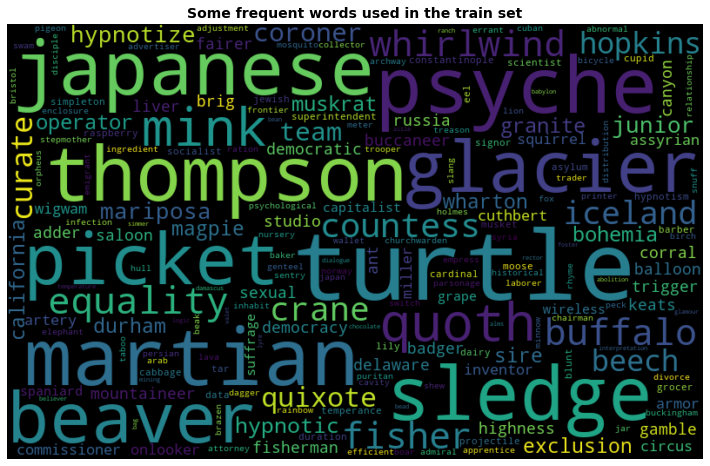

In [13]:
# Now lets visualize a word cloud of our books
all_freq = sum([Counter({id2word[k]: freq for k, freq in cp}) for cp in corpus], start=Counter())

wordcloud = WordCloud(width=800, height=500, max_font_size=110).generate_from_frequencies(all_freq)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent words used in the train set", weight='bold', fontsize=14)
plt.show()

## Modeling

In this stage we are going to use the LDA algorithm from the gensim library to train and test the topic modeling algorithm for our dataset. We can look at different numbers of topics and choose the parameters that yield the best results. To do this we will make use of the coherence metric. Before we understand topic coherence, let’s briefly look at the perplexity measure. Perplexity as well is one of the intrinsic evaluation metric, and is widely used for language model evaluation. It captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set. Focussing on the log-likelihood part, you can think of the perplexity metric as measuring how probable some new unseen data is given the model that was learned earlier. That is to say, how well does the model represent or reproduce the statistics of the held-out data. However, recent studies have shown that predictive likelihood (or equivalently, perplexity) and human judgment are often not correlated, and even sometimes slightly anti-correlated. This limitation of perplexity measure served as a motivation for more work trying to model the human judgment, and thus Topic Coherence. The concept of topic coherence combines a number of measures into a framework to evaluate the coherence between topics inferred by a model. Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference. A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts. An example of a coherent fact set is "the game is a team sport", "the game is played with a ball", "the game demands great physical efforts".

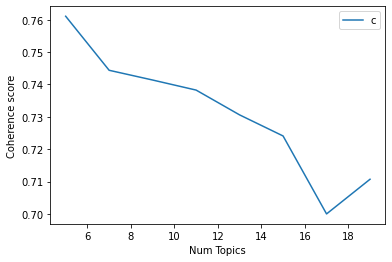

In [14]:
coherence_values = []
model_list = []
x = range(5, 21, 2)

for num_topics in x:
    model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=df['TEXT'], dictionary=id2word, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

# Show graph
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [15]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
best = np.array(coherence_values).argmax()

lda_model_c = coherence_values[best]
lda_model = model_list[best]

num_topics = x[best]

print(f"Choosing the LDA model with {num_topics} topics")
optimal_model = lda_model

# Select the model and print the topics
model_topics = optimal_model.show_topics(num_topics=num_topics, formatted=False)
pprint(optimal_model.print_topics(num_words=10))

Num Topics = 5  has Coherence Value of 0.7611
Num Topics = 7  has Coherence Value of 0.7444
Num Topics = 9  has Coherence Value of 0.7414
Num Topics = 11  has Coherence Value of 0.7383
Num Topics = 13  has Coherence Value of 0.7306
Num Topics = 15  has Coherence Value of 0.7241
Num Topics = 17  has Coherence Value of 0.7
Num Topics = 19  has Coherence Value of 0.7107
Choosing the LDA model with 5 topics
[(0,
  '0.005*"glacier" + 0.003*"sledge" + 0.003*"quixote" + 0.002*"hypnotize" + '
  '0.002*"canyon" + 0.002*"granite" + 0.002*"onlooker" + 0.002*"hypnotic" + '
  '0.002*"japanese" + 0.002*"fisher"'),
 (1,
  '0.005*"beaver" + 0.004*"martian" + 0.004*"iceland" + 0.003*"turtle" + '
  '0.003*"buccaneer" + 0.003*"balloon" + 0.002*"simpleton" + 0.002*"spaniard" '
  '+ 0.002*"fisherman" + 0.002*"grape"'),
 (2,
  '0.005*"psyche" + 0.004*"turtle" + 0.003*"buffalo" + 0.003*"whirlwind" + '
  '0.003*"california" + 0.002*"coroner" + 0.002*"exclusion" + 0.002*"cupid" + '
  '0.002*"temperance" + 0.00

In [16]:
pyLDAvis.enable_notebook()
data = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
pyLDAvis.save_html(data, pyLDAvis_outpath)
data

/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alterna

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.004684  0.040495       1        1  21.573181
1      0.022144 -0.042523       2        1  20.957379
0     -0.004860  0.027506       3        1  20.656521
4      0.034940 -0.006143       4        1  19.783132
3     -0.056908 -0.019334       5        1  17.029787, topic_info=           Term       Freq      Total Category  logprob  loglift
301    thompson  33.000000  33.000000  Default  30.0000  30.0000
2589     beaver  31.000000  31.000000  Default  29.0000  29.0000
1395     psyche  38.000000  38.000000  Default  28.0000  28.0000
4295    glacier  34.000000  34.000000  Default  27.0000  27.0000
663     iceland  24.000000  24.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
3349  hypnotism   5.024040  15.093685   Topic5  -6.7708   0.6702
3960   cuthbert   5.124619  16.559154   Topic5  -6.7510   0.5973
1395     psyche   6.435650  38.536911   Topic5  -6.5232  -0.0196
3246     turtle   7.118789  58.339838   Topic5  -6.4223  -0.3333
2528   assyrian   5.045016  16.783312   Topic5  -6.7667   0.5682

[315 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1491      3  0.589932  accomplice
1491      5  0.294966  accomplice
2732      1  0.340861       adder
2732      2  0.284051       adder
2732      3  0.113620       adder
...     ...       ...         ...
3982      3  0.100771  winchester
3982      5  0.201541  winchester
4436      1  0.584630     woodley
4436      2  0.350778     woodley
4436      3  0.116926     woodley

[926 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 5, 4])

In [17]:
# Get the topic keywords
topic_keywords = [([word for word, prop in optimal_model.show_topic(t)]) for t in range(num_topics)]
topic_keywords_df = pd.DataFrame({'Topic_Keywords': topic_keywords})
topic_keywords_df

,Topic_Keywords
0,"[glacier, sledge, quixote, hypnotize, canyon, ..."
1,"[beaver, martian, iceland, turtle, buccaneer, ..."
2,"[psyche, turtle, buffalo, whirlwind, californi..."
3,"[thompson, team, junior, fisher, operator, bad..."
4,"[japanese, picket, quoth, keats, beech, durham..."


['psyche', 'turtle', 'buffalo', 'whirlwind', 'california', 'coroner', 'exclusion', 'cupid', 'temperance', 'commissioner']


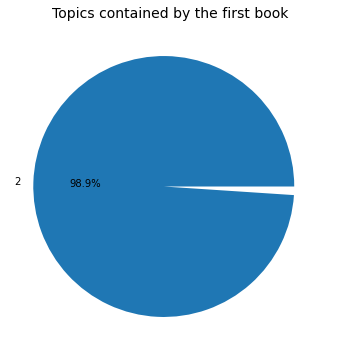

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Text,Book
0,0,2.0,"[0, 0, 0.9895, 0, 0]","[till, would, finally, circle, round, round, m...","The Life of Hon. William F. Cody, Known as Buf..."
1,1,1.0,"[0, 0.8439, 0.1513, 0, 0]","[cincinnatus, quiet, beautiful, life, citizen,...","Divine Comedy, Longfellow's Translation, Complete"
2,2,1.0,"[0, 0.69, 0, 0.2996, 0]","[last, full, knowledge, cousin, desire, increa...",Aunt Jane's Nieces
3,3,3.0,"[0, 0, 0, 0.9821, 0]","[mode, beard, oyster, scald, liquor, well, str...",The Book of Household Management
4,4,2.0,"[0, 0, 0.9761, 0, 0]","[say, absolutely, certain, wisdom, step, take,...",The Professor
5,5,3.0,"[0, 0, 0, 0.9856, 0]","[never, notice, wealth, pile, discover, accide...",Aunt Jane's Nieces at Millville
6,6,1.0,"[0, 0.6665, 0.3169, 0, 0]","[thing, hurtful, doctrine, appear, inexpugnabl...",Autobiography
7,7,1.0,"[0, 0.7697, 0, 0.2156, 0]","[purple, pride, soft, cheek, complexion, dwell...",Shakespeare's Sonnets
8,8,3.0,"[0, 0, 0, 0.9919, 0]","[vacation, college, upon, edge, surgery, table...",The Green Flag
9,9,2.0,"[0, 0, 0.9838, 0, 0]","[thump, touch, depth, affection, heart, give, ...",Three John Silence Stories


In [18]:
# Finding the dominant topic in each book
# Init output
dominant_topic_df = pd.DataFrame()

# Get main topic in each document
for i, row in enumerate(optimal_model[corpus]):
    topic_num, _ = sorted(row, key=lambda x: (x[1]), reverse=True)[0]
    prop_topics = {t: round(p, 4) for t, p in row}
    prop_topics = [prop_topics.get(t, 0) for t in range(num_topics)]
    dominant_topic_df = dominant_topic_df.append(pd.Series([int(topic_num), prop_topics]), ignore_index=True)
dominant_topic_df.columns = ['Dominant_Topic', 'Perc_Contribution']

dominant_topic_df = pd.concat([dominant_topic_df,  pd.Series(df['TEXT'].to_list()),  pd.Series(df['BOOK'].to_list())], axis=1)

# Format
dominant_topic_df = dominant_topic_df.reset_index()
dominant_topic_df.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Text', 'Book']

# Show
example_row = dominant_topic_df.iloc[0]
pie, ax = plt.subplots(figsize=[10,6])
data = {k: v for k, v in zip(list(range(num_topics)), example_row['Topic_Perc_Contrib']) if v > 0}
for k, v in data.items():
    print(topic_keywords_df['Topic_Keywords'][k])
plt.pie(x=data.values(), autopct="%.1f%%", explode=[0.05]*len(data.keys()), labels=data.keys(), normalize=False)
plt.title("Topics contained by the first book", fontsize=14)
plt.show()

dominant_topic_df.head(10)

In [19]:
# Find the most representative document for each topic
# Group top 5 sentences under each topic
topic_contrib_df = dominant_topic_df.copy(deep=True)
best_book_topic_df = pd.DataFrame()

for i in range(num_topics):
    bookid = dominant_topic_df['Topic_Perc_Contrib'].apply(lambda p: p[i]).argmax()
    best_book_topic_df = best_book_topic_df.append(pd.Series([i, int(bookid), dominant_topic_df['Text'][bookid], dominant_topic_df['Book'][bookid]]), ignore_index=True)

best_book_topic_df.columns = ['Topic_Num', 'Document_No', 'Text', 'Book']
best_book_topic_df

,Topic_Num,Document_No,Text,Book
0,0.0,122.0,"[complete, rest, complete, change, life, lengt...",Psychotherapy
1,1.0,263.0,"[within, fifty, foot, unclasp, enormous, metal...",A Princess of Mars
2,2.0,172.0,"[avoid, permanent, damage, five, thousand, foo...",Steep Trails
3,3.0,69.0,"[believe, stage, admit, say, laugh, take, idea...","Grace Harlowe's Junior Year at High School Or,..."
4,4.0,194.0,"[trophy, sport, think, mistaken, believe, pick...",Jailed for Freedom


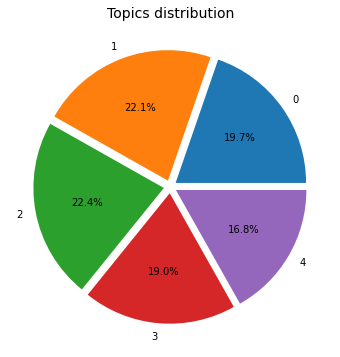

,Topic_Num,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0,"[glacier, sledge, quixote, hypnotize, canyon, ...",82,0.1971
1.0,1,"[beaver, martian, iceland, turtle, buccaneer, ...",92,0.2212
2.0,2,"[psyche, turtle, buffalo, whirlwind, californi...",93,0.2236
3.0,3,"[thompson, team, junior, fisher, operator, bad...",79,0.1899
4.0,4,"[japanese, picket, quoth, keats, beech, durham...",70,0.1683


In [20]:
# Topic distribution across documents

# Number of Documents for Each Topic
topic_counts = dominant_topic_df['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Concatenate Column wise
topics_distribution_df = pd.concat([pd.DataFrame(range(num_topics)), topic_keywords_df, topic_counts, topic_contribution], axis=1)

# Change Column names
topics_distribution_df.columns = ['Topic_Num', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']
topics_distribution_df = topics_distribution_df.fillna(0)

# Show
pie, ax = plt.subplots(figsize=[10,6])
data = {k: v for k, v in zip(topics_distribution_df['Topic_Num'], topics_distribution_df['Perc_Documents']) if v > 0}
plt.pie(x=data.values(), autopct="%.1f%%", explode=[0.05]*len(data.keys()), labels=data.keys(), normalize=True)
plt.title("Topics distribution", fontsize=14)
plt.show()

topics_distribution_df

In [21]:
# Run inference on a book example
x = word_tokenize("This is an example of how to run inference but it is a short book".lower())
x = id2word.doc2bow(x)
y_hat = optimal_model[[x]]

Predicted topic for the book "None" are
4 and contains ['japanese', 'picket', 'quoth', 'keats', 'beech', 'durham', 'bohemia', 'wharton', 'russia', 'magpie'] keywords.
1 and contains ['beaver', 'martian', 'iceland', 'turtle', 'buccaneer', 'balloon', 'simpleton', 'spaniard', 'fisherman', 'grape'] keywords.
0 and contains ['glacier', 'sledge', 'quixote', 'hypnotize', 'canyon', 'granite', 'onlooker', 'hypnotic', 'japanese', 'fisher'] keywords.
2 and contains ['psyche', 'turtle', 'buffalo', 'whirlwind', 'california', 'coroner', 'exclusion', 'cupid', 'temperance', 'commissioner'] keywords.
3 and contains ['thompson', 'team', 'junior', 'fisher', 'operator', 'badger', 'countess', 'artery', 'equality', 'liver'] keywords.


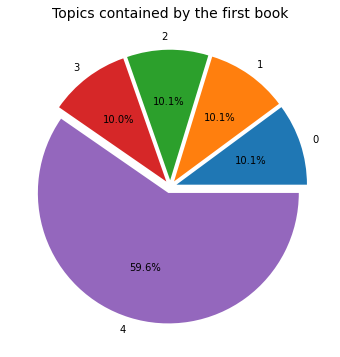

In [22]:
_threshold = 0.05
data = {k: v for k, v in y_hat[0] if v >= _threshold}
topics = sorted(data.items(), key=lambda e: e[1], reverse=True)
print(f"Predicted topic for the book \"{None}\" are")
for k, v in topics:
    print(f"{k} and contains {topic_keywords[k]} keywords.")

pie, ax = plt.subplots(figsize=[10, 6])

plt.pie(x=data.values(), autopct="%.1f%%", explode=[0.05]*len(data.keys()), labels=data.keys(), normalize=True)
plt.title("Topics contained by the first book", fontsize=14)
plt.show()

In [23]:
id2word.save(id2word_outpath)
optimal_model.save(optimal_model_outpath)